# Classificatie modellen

In [1]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Connectie maken met de database

In [2]:
# database name
DB = {
    'servername': '(local)\\SQLEXPRESS',
    'database': 'DEDS_DataWarehouse'}

In [3]:
export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')


# Create a cursor from the connection
export_cursor = export_conn.cursor()

# check if connection is successful, else throw an error
if export_conn:
    print("Connection with database is established")
else:
    print("Connection with database is not established")
    raise Exception("Connection with database is not established")

Connection with database is established


# Tabellen inlezen

In [4]:
returned_item_query = "SELECT * FROM Returned_item WHERE CURRENT_VALUE = 1"

returned_item_result = export_cursor.execute(returned_item_query)
returned_item_fetch = returned_item_result.fetchall()
returned_item_columns = [column[0] for column in returned_item_result.description]
returned_item = pd.DataFrame.from_records(returned_item_fetch, columns=returned_item_columns)

# Dropping current_value and last_updated columns
returned_item = returned_item.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

returned_item

,RETURNED_ITEM_SK,RETURNED_ITEM_code,RETURNED_ITEM_DATE,RETURNED_ITEM_QUANTITY,RETURNED_ITEM_ORDER_DETAIL_CODE,RETURNED_ITEM_RETURN_REASON_code,RETURNED_ITEM_RETURN_REASON_description_en,RETURNED_ITEM_RETURNED_ITEMS_TOTAL_PRICE
0,1,1491,2021-01-08,8,34668,5,Unsatisfactory product,180.3200
1,2,1492,2020-06-12,2,34257,2,Incomplete product,45.0800
2,3,1493,2021-06-24,22,34677,4,Wrong product shipped,495.8800
3,4,1494,2021-07-21,20,34683,3,Wrong product ordered,450.8000
4,5,1496,2020-07-10,2,34305,1,Defective product,45.0800
...,...,...,...,...,...,...,...,...
701,702,2465,2021-06-06,24,14153,3,Wrong product ordered,287.2800
702,703,2466,2021-06-10,66,14164,5,Unsatisfactory product,710.8200
703,704,2467,2022-03-31,64,14396,4,Wrong product shipped,689.2800
704,705,2468,2022-12-23,2,14352,1,Defective product,21.5400


In [5]:
order_details_query = "SELECT * FROM Order_details WHERE CURRENT_VALUE = 1"

order_details_result = export_cursor.execute(order_details_query)
order_details_fetch = order_details_result.fetchall()
order_details_columns = [column[0] for column in order_details_result.description]
order_details = pd.DataFrame.from_records(order_details_fetch, columns=order_details_columns)

# dropping current value and last updated columns
order_details = order_details.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

order_details

,ORDER_DETAILS_SK,ORDER_DETAILS_code,ORDER_DETAILS_QUANTITY_quantity,ORDER_DETAILS_TOTAL_COST_total,ORDER_DETAILS_TOTAL_MARGIN_margin,ORDER_DETAILS_ORDER_NUMBER_order,ORDER_DETAILS_PRODUCT_NUMBER_product,ORDER_DETAILS_UNIT_ID_unit
0,1,100000,16,257.6000,360.6400,4405,112,1
1,2,100001,20,322.0000,450.8000,5008,112,2
2,3,100002,24,386.4000,540.9600,4394,112,3
3,4,100003,18,289.8000,405.7200,4396,112,4
4,5,100004,20,322.0000,450.8000,4382,112,5
...,...,...,...,...,...,...,...,...
43058,43059,99995,146,402.9600,810.3000,4402,111,43059
43059,43060,99996,172,474.7200,954.6000,4400,111,43060
43060,43061,99997,192,529.9200,1065.6000,5148,111,43061
43061,43062,99998,192,529.9200,1065.6000,4384,111,43062


In [6]:
unit_query = "SELECT * FROM Unit WHERE CURRENT_VALUE = 1"

unit_result = export_cursor.execute(unit_query)
unit_fetch = unit_result.fetchall()
unit_columns = [column[0] for column in unit_result.description]
unit = pd.DataFrame.from_records(unit_fetch, columns=unit_columns)

# dropping current value and last updated columns
unit = unit.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

unit

,UNIT_SK,UNIT_id,UNIT_COST_cost,UNIT_PRICE_price,UNIT_SALE_sale
0,1,1,16.1000,22.5400,22.5400
1,2,2,16.1000,22.5400,22.5400
2,3,3,16.1000,22.5400,22.5400
3,4,4,16.1000,22.5400,22.5400
4,5,5,16.1000,22.5400,22.5400
...,...,...,...,...,...
43058,43059,43059,2.7600,5.5500,5.5500
43059,43060,43060,2.7600,5.5500,5.5500
43060,43061,43061,2.7600,5.5500,5.5500
43061,43062,43062,2.7600,5.5500,5.5500


# Database connectie sluiten

In [7]:
export_cursor.close()
export_conn.close()

# Data samenvoegen

In [8]:
data = pd.merge(unit, order_details, left_on='UNIT_SK', right_on='ORDER_DETAILS_UNIT_ID_unit')
data = pd.merge(returned_item, data, how='right', left_on='RETURNED_ITEM_ORDER_DETAIL_CODE', right_on='ORDER_DETAILS_SK')

data

,RETURNED_ITEM_SK,RETURNED_ITEM_code,RETURNED_ITEM_DATE,RETURNED_ITEM_QUANTITY,RETURNED_ITEM_ORDER_DETAIL_CODE,RETURNED_ITEM_RETURN_REASON_code,RETURNED_ITEM_RETURN_REASON_description_en,RETURNED_ITEM_RETURNED_ITEMS_TOTAL_PRICE,UNIT_SK,UNIT_id,...,UNIT_PRICE_price,UNIT_SALE_sale,ORDER_DETAILS_SK,ORDER_DETAILS_code,ORDER_DETAILS_QUANTITY_quantity,ORDER_DETAILS_TOTAL_COST_total,ORDER_DETAILS_TOTAL_MARGIN_margin,ORDER_DETAILS_ORDER_NUMBER_order,ORDER_DETAILS_PRODUCT_NUMBER_product,ORDER_DETAILS_UNIT_ID_unit
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,22.5400,22.5400,1,100000,16,257.6000,360.6400,4405,112,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,...,22.5400,22.5400,2,100001,20,322.0000,450.8000,5008,112,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,...,22.5400,22.5400,3,100002,24,386.4000,540.9600,4394,112,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,...,22.5400,22.5400,4,100003,18,289.8000,405.7200,4396,112,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,...,22.5400,22.5400,5,100004,20,322.0000,450.8000,4382,112,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43059,43059,...,5.5500,5.5500,43059,99995,146,402.9600,810.3000,4402,111,43059
43059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43060,43060,...,5.5500,5.5500,43060,99996,172,474.7200,954.6000,4400,111,43060
43060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43061,43061,...,5.5500,5.5500,43061,99997,192,529.9200,1065.6000,5148,111,43061
43061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43062,43062,...,5.5500,5.5500,43062,99998,192,529.9200,1065.6000,4384,111,43062


# Data voorbereiden

In [9]:
# removing the sk columns
sk_columns = data.filter(like='SK').columns
data.drop(columns=sk_columns, inplace=True)

#removing unnecessary columns
drop_columns = ['RETURNED_ITEM_RETURN_REASON_description_en', 'ORDER_DETAILS_UNIT_ID_unit', 'RETURNED_ITEM_code', 'ORDER_DETAILS_code', 'ORDER_DETAILS_ORDER_NUMBER_order', 'RETURNED_ITEM_ORDER_DETAIL_CODE', 'RETURNED_ITEM_DATE', 'RETURNED_ITEM_QUANTITY', 'RETURNED_ITEM_RETURNED_ITEMS_TOTAL_PRICE', 'UNIT_id', 'ORDER_DETAILS_TOTAL_COST_total', 'ORDER_DETAILS_TOTAL_MARGIN_margin']
data.drop(columns=drop_columns, inplace=True)

data

,RETURNED_ITEM_RETURN_REASON_code,UNIT_COST_cost,UNIT_PRICE_price,UNIT_SALE_sale,ORDER_DETAILS_QUANTITY_quantity,ORDER_DETAILS_PRODUCT_NUMBER_product
0,NaN,16.1000,22.5400,22.5400,16,112
1,NaN,16.1000,22.5400,22.5400,20,112
2,NaN,16.1000,22.5400,22.5400,24,112
3,NaN,16.1000,22.5400,22.5400,18,112
4,NaN,16.1000,22.5400,22.5400,20,112
...,...,...,...,...,...,...
43058,NaN,2.7600,5.5500,5.5500,146,111
43059,NaN,2.7600,5.5500,5.5500,172,111
43060,NaN,2.7600,5.5500,5.5500,192,111
43061,NaN,2.7600,5.5500,5.5500,192,111


In [10]:
# converting the columns to the correct datatypes
data['RETURNED_ITEM_RETURN_REASON_code'] = data['RETURNED_ITEM_RETURN_REASON_code'].fillna(-1).astype('category')
data['UNIT_COST_cost'] = data['UNIT_COST_cost'].astype('float')
data['UNIT_PRICE_price'] = data['UNIT_PRICE_price'].astype('float')
data['UNIT_SALE_sale'] = data['UNIT_SALE_sale'].astype('float')
data['ORDER_DETAILS_QUANTITY_quantity'] = data['ORDER_DETAILS_QUANTITY_quantity'].astype('int')
data['ORDER_DETAILS_PRODUCT_NUMBER_product'] = data['ORDER_DETAILS_PRODUCT_NUMBER_product'].astype('int')

data.dtypes

RETURNED_ITEM_RETURN_REASON_code        category
UNIT_COST_cost                           float64
UNIT_PRICE_price                         float64
UNIT_SALE_sale                           float64
ORDER_DETAILS_QUANTITY_quantity            int32
ORDER_DETAILS_PRODUCT_NUMBER_product       int32
dtype: object

# Classificatie model trainen

In [11]:
# Splitting the data
X = data.drop(columns=['RETURNED_ITEM_RETURN_REASON_code'])
y = data['RETURNED_ITEM_RETURN_REASON_code']

# splitting with a seed value, so it is always the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# Training the model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

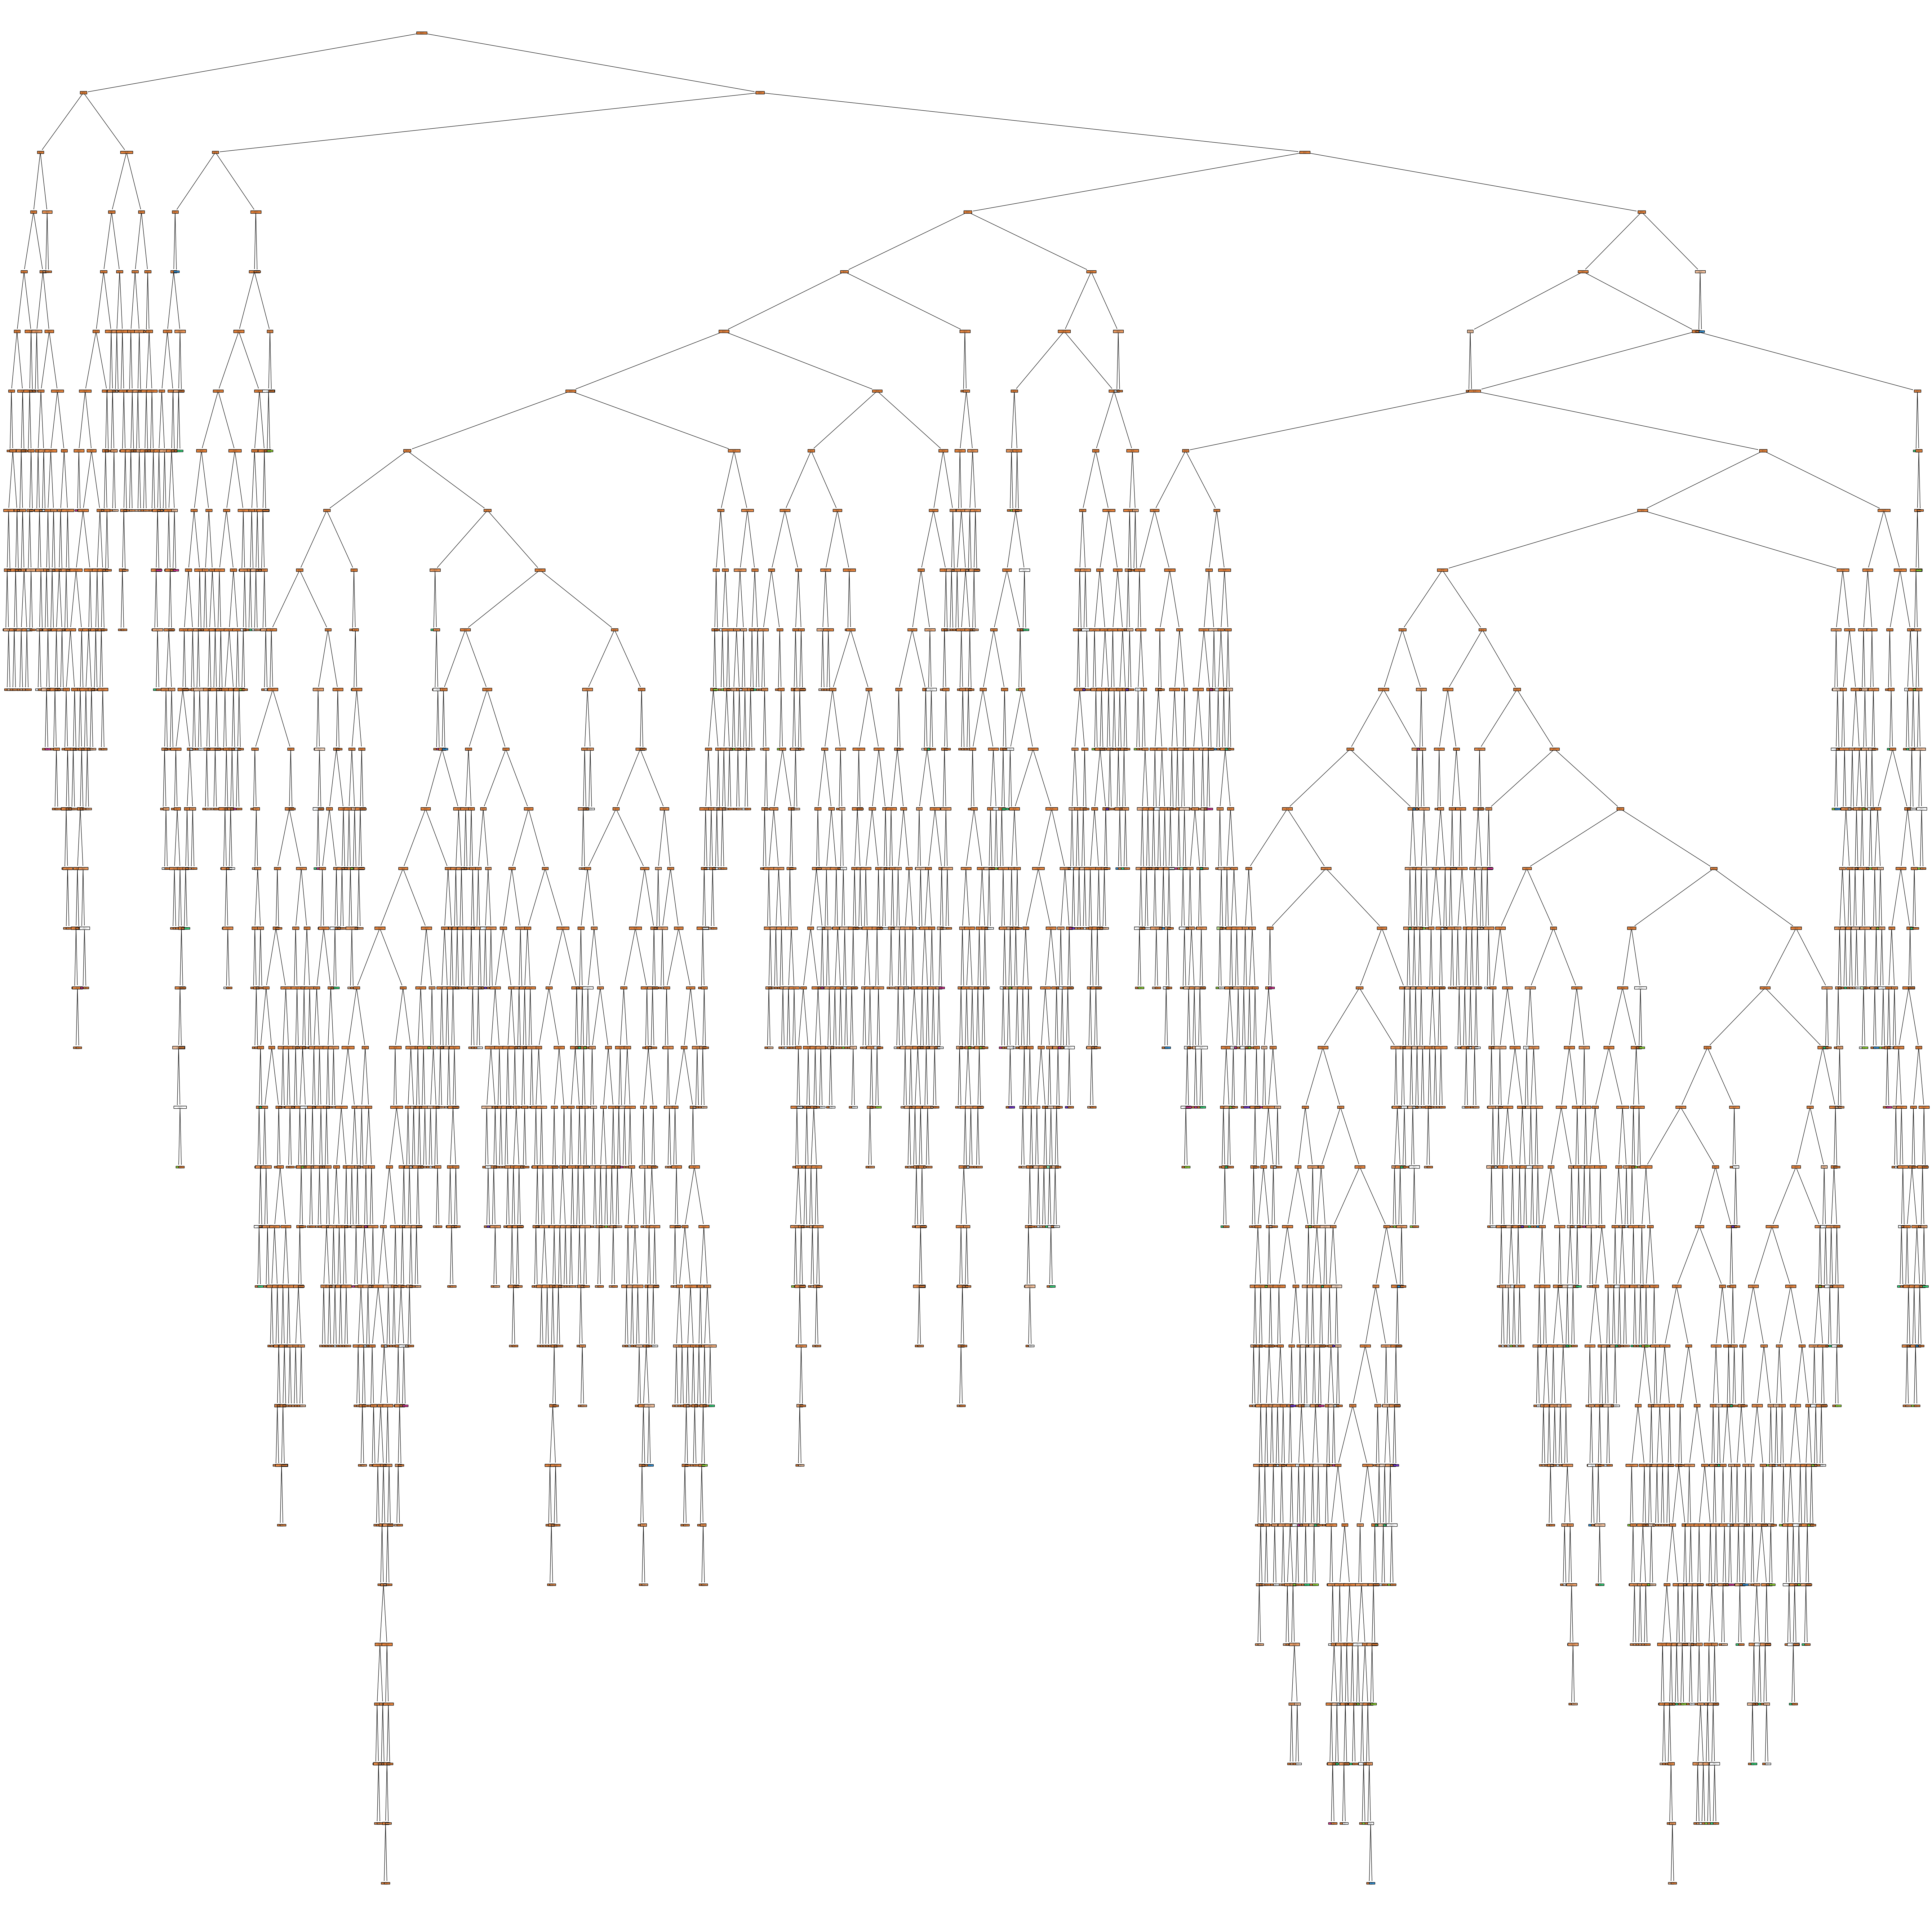

In [17]:
# Convert column names to strings
X.columns = X.columns.astype(str)

# Convert target classes to string representation
class_names = [str(cls) for cls in model.classes_]

# Plot the decision tree
plt.figure(figsize=(80,80))  # Set the figure size
plot_tree(model, filled=True, feature_names=X.columns, class_names=class_names)

# Save the plot as SVG file
plt.savefig('decision_tree.svg', format='svg')  # Save as SVG format

In [14]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
sse = mse * len(y_test)

print(f'Accuracy: {accuracy}')
print(f'Mean Squared Error: {mse}')
print(f'Sum of Squared Errors: {sse}')

Accuracy: 0.9741089051433879
Mean Squared Error: 0.33693254382909554
Sum of Squared Errors: 2902.0


# Confusion matrix

In [15]:
# Importing the confusion matrix
from sklearn.metrics import confusion_matrix

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 0
True Negatives: 8390
False Positives: 35
False Negatives: 56
